In [3]:
from collections import Counter, defaultdict, namedtuple
from functools import partial
import math, random

In [4]:
%install_ext https://raw.github.com/tkf/ipython-hierarchymagic/master/hierarchymagic.py

Installed hierarchymagic.py. To use it, type:
  %load_ext hierarchymagic


In [5]:
%load_ext hierarchymagic

# Decision Trees

Decision trees are another type of classifier we can use in the same way we can use a Naive Bayes classifier. They work much differently, however.

A decision tree is basically a tree of if statements and could be coded by hand, like the following example.

In [26]:
# What is the type of an animal?
# Does it have a backbone?
#     If it's cold-blooded:
#       - Is it born in the water?
#         - Does it have lungs as an adult? Amphibian.
#         - Else: Fish.
#       - Else: Reptile.
#     Else:
#       - Does it drink milk as a baby? Mammal.
#       - Else: Bird.
# Else:
#     Arthropod.

Animal = namedtuple("Animal", "has_backbone,cold_blooded,born_in_water,breathes_air,milk_drinker")

crow = Animal(True, False, False, True, False)
bass = Animal(True, True, True, False, False)
spider = Animal(False, True, False, True, False)
rattlesnake = Animal(True, True, False, True, False)

def animal_type(animal):
    if animal.has_backbone:
        if animal.cold_blooded:
            if animal.born_in_water:
                if animal.breathes_air:
                    return "amphibian"
                else:
                    return "fish"
            else:
                return "reptile"
        else:
            if animal.milk_drinker:
                return "mammal"
            else:
                return "bird"
    else:
        return "arthropod"

print("bass", animal_type(bass))
print("crow", animal_type(crow))

bass fish
crow bird


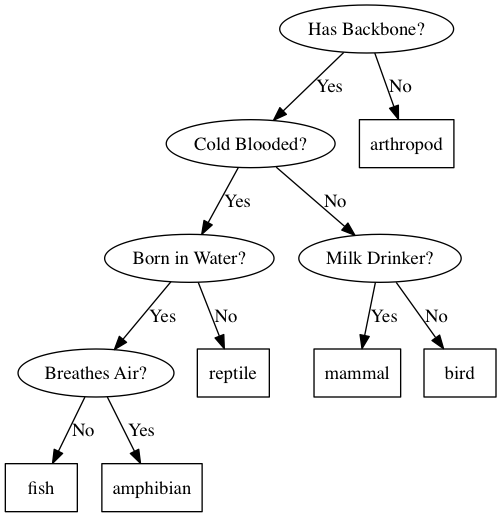

In [7]:
%%dot
digraph animal_type {
    A [label="Has Backbone?"]
    B [label="Cold Blooded?"]
    C [label="Born in Water?"]
    D [label="Breathes Air?"]
    E [label="Milk Drinker?"]
    arthropod, reptile, mammal, fish, amphibian, bird [shape=rectangle]
    A -> B [label=Yes]
    A -> arthropod [label=No]
    B -> C [label=Yes]
    C -> D [label=Yes]
    C -> reptile [label=No]
    D -> amphibian [label=Yes]
    D -> fish [label=No]
    B -> E [label=No]
    E -> mammal [label=Yes]
    E -> bird [label=No]
}

When we're dealing with a lot of data we want to classify and we don't know how to choose its classification, we can't create this by hand, so we use a decision tree algorithm that can learn from our training data.

**NOTE**: A big difference with decision trees compared to Naive Bayes is that it can use categories, not just numbers, as features.

A decision tree works by looking at the different features it could split a dataset on, and then it chooses the attribute that produces the least entropy -- that is, it generates the most uniform subset. From here, it continues to partition the dataset until it reaches a subset that is completely uniform or until there's no more features to partition with.

The following code finds the entropy of a dataset. The dataset should be a list of tuples, with each tuple having a feature vector and a label. As for the equation that finds the entropy, you'll have to trust the math on that one.

I'm going to use real data for this: it's data about mushrooms that are labeled as poisonous or not.

In [27]:
def entropy(class_probabilities):
    """given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2) for p in class_probabilities if p)

def class_probabilities(labels):
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labeled_data):        
    labels = [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

In [28]:
import csv
mushroom_data = []
columns = ["poisonous", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", 
           "gill-attachment", "gill-spacing", "gill-size", "gill-color", 
           "stalk-shape", "stalk-root",  "stalk-surface-above-ring", 
           "stalk-surface-below-ring", "stalk-color-above-ring", 
           "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", 
           "ring-type", "spore-print-color", "population", "habitat"]
with open("agaricus-lepiota.data") as file:
    reader = csv.DictReader(file, fieldnames=columns)
    for row in reader:
        poisonous = True if row.pop("poisonous") == "p" else False
        mushroom_data.append((row, poisonous))
    
print(len(mushroom_data))
data_entropy(mushroom_data)

8124


0.9990678968724604

Now we need a way to partition our data, and a way to see the entropy of the subsets.

In [10]:
def partition_by(inputs, attribute):
    """returns a dict of inputs partitioned by the attribute
    each input is a pair (attribute_dict, label)"""
    groups = defaultdict(list)
    for item in inputs:
        key = item[0][attribute]
        groups[key].append(item)
    return groups

def partition_entropy(subsets):
    """find the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)
    
    return sum( data_entropy(subset) * len(subset) / total_count
                for subset in subsets )

def partition_entropy_by(inputs, attribute):
    """computes the entropy corresponding to the given partition"""        
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())     

In [11]:
feature_names = columns[1:]
for name in feature_names:
    print(name, partition_entropy_by(mushroom_data, name))

cap-shape 0.9502711949370874
cap-surface 0.9704776640986876
cap-color 0.9630186138962564
bruises 0.8066884111112408
odor 0.09299291948846061
gill-attachment 0.9849028696218443
gill-spacing 0.8981847128758902
gill-size 0.7689135217244145
gill-color 0.5820903734563291
stalk-shape 0.991551124302796
stalk-root 0.8642502592451846
stalk-surface-above-ring 0.7143422976539759
stalk-surface-below-ring 0.7271734234797139
stalk-color-above-ring 0.7452227234102206
stalk-color-below-ring 0.757652330344894
veil-type 0.9990678968724604
veil-color 0.9752508807515435
ring-number 0.96061522762937
ring-type 0.6810463860789229
spore-print-color 0.518362979187545
population 0.7971098778056079
habitat 0.8422342922673685


We can see that odor has the lowest entropy, with spore-print-color trailing a distant second.

## Building Decision Trees

To build a decision tree, we'll use an algorithm called the [ID3 algorithm](https://en.wikipedia.org/wiki/ID3_algorithm). From the Wikipedia page, here's the summary of the algorithm:

1. Calculate the entropy of every attribute using the data set S.
2. Split the set S into subsets using the attribute for which entropy is minimum.
3. Make a decision tree node containing that attribute.
4. Recur on subsets using remaining attributes.

For our implementation, a tree will be either a label, or a tuple `(attribute, subtree_dict)`. `subtree_dict` has the possible values for the attribute as keys and subtrees as values.

In [29]:
def build_tree_id3(inputs, split_candidates=None):

    # if this is our first pass, 
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()

    # count labels in the inputs
    num_inputs = len(inputs)
    label_counter = Counter([label for item, label in inputs])
    most_common = label_counter.most_common()[0][0]
    
    if len(label_counter.keys()) == 1:
        return most_common
    
    if not split_candidates:            # if no split candidates left
        return most_common  # return the majority leaf
                            
    # otherwise, split on the best attribute
    best_attribute = min(split_candidates,
        key=partial(partition_entropy_by, inputs))

    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates 
                      if a != best_attribute]
    
    # recursively build the subtrees
    subtrees = { attribute : build_tree_id3(subset, new_candidates)
                 for attribute, subset in partitions.items() }

    subtrees[None] = most_common # default case

    return (best_attribute, subtrees)

In [30]:
build_tree_id3(mushroom_data)

('odor',
 {'m': True,
  'a': False,
  's': True,
  None: False,
  'l': False,
  'p': True,
  'f': True,
  'c': True,
  'y': True,
  'n': ('spore-print-color',
   {'r': True,
    'b': False,
    'n': False,
    'w': ('habitat',
     {'g': False,
      'w': False,
      'd': ('stalk-root', {'b': False, '?': True, None: True}),
      'l': ('stalk-color-below-ring',
       {'w': True, 'n': False, 'y': True, None: False}),
      'p': False,
      None: False}),
    'o': False,
    'k': False,
    'h': False,
    'y': False,
    None: False})})

Translated:

- If the odor is musty, spicy, fishy, pungent, creosote, or foul, it's poisonous.
- If it's almond or anise, it's not poisonous.
- If there's no odor, look at the spore print color:
  - If it's green, it's poisonous.
  - If it's white, check the habitat:
    - If it's woods, check the stalk color above ring:
      - If it's white or unknown, poisonous.
      - If it's brown, not poisonous.
    - If it's leaves, check the cap color:
      - If it's yellow, it's poisonous.
      - Otherwise, not poisonous.
  - Otherwise, it's not poisonous.
  
Now let's classify this data with the decision tree. In order to have some unknown data, I'm going to split our mushroom data.

In [14]:
def classify(tree, input):
    """classify the input using the given decision tree"""
    
    # if this is a leaf node, return its value
    if type(tree) != tuple:
        return tree
   
    # otherwise find the correct subtree
    attribute, subtree_dict = tree
    
    subtree_key = input.get(attribute)  # None if input is missing attribute

    if subtree_key not in subtree_dict: # if no subtree for key,
        subtree_key = None              # we'll use the None subtree
    
    subtree = subtree_dict[subtree_key] # choose the appropriate subtree
    return classify(subtree, input)     # and use it to classify the input

class DecisionTree:
    def __init__(self):
        self.tree = None
        
    def fit(self, X, y):
        self.tree = build_tree_id3(list(zip(X, y)))
        return self
        
    def predict(self, X):
        results = []
        for x in X:
            results.append(classify(self.tree, x))
        return results
            
    def score(self, X, y):
        results = self.predict(X)
        correct = 0
        for idx in range(len(y)):
            if y[idx] == results[idx]:
                correct += 1
        return correct / len(y)

In [39]:
def unzip(data):
    return [d[0] for d in data], [d[1] for d in data]

from sklearn.cross_validation import train_test_split
X, y = unzip(mushroom_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

tree = DecisionTree()
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

1.0

While we'd expect a classifier to not be 100% accurate, in this case, that's correct. See [the data README](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names) for more details.

Let's take some data about candidates we've hired in the past and whether they've worked out well and use that to weed out applicants.

In [41]:
hires = [
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
    ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
    ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
    ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
    ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
    ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
]

tree = build_tree_id3(hires)

print("Junior / Java / tweets / no phd:", 
      classify(tree, {"level": "Junior", 
                      "lang": "Java", 
                      "tweets": "yes", 
                      "phd": "no"}))

print("Mid / Python / tweets / phd:", 
      classify(tree, {"level": "Mid", 
                      "lang": "Python", 
                      "tweets": "yes", 
                      "phd": "yes"}))

print("Senior / Python / no tweets / phd:", 
      classify(tree, {"level": "Senior", 
                      "lang": "Python", 
                      "tweets": "no", 
                      "phd": "yes"}))

print({"level": "Senior", 
       "lang": "Python", 
       "tweets": "no", 
       "phd": "yes"} not in [h[0] for h in hires])

tree

Junior / Java / tweets / no phd: True
Mid / Python / tweets / phd: True
Senior / Python / no tweets / phd: False
True


('level',
 {'Junior': ('phd', {'no': True, None: True, 'yes': False}),
  'Senior': ('tweets', {'no': False, None: False, 'yes': True}),
  None: True,
  'Mid': True})

Let's try one more thing. Given a dataset of poker hands, can we predict/understand the hand of any five cards?

In [17]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand.names    

  HTTP/1.1 200 OK
  Date: Thu, 04 Jun 2015 12:27:41 GMT
  Server: Apache/2.2.15 (CentOS)
  Last-Modified: Mon, 26 Feb 2007 06:46:48 GMT
  ETag: "17305acd-95d3e-42a5b81634600"
  Accept-Ranges: bytes
  Content-Length: 613694
  Content-Type: text/plain; charset=UTF-8
  HTTP/1.1 200 OK
  Date: Thu, 04 Jun 2015 12:27:42 GMT
  Server: Apache/2.2.15 (CentOS)
  Last-Modified: Mon, 26 Feb 2007 06:46:14 GMT
  ETag: "17305acc-1766cdd-42a5b7f5c7980"
  Accept-Ranges: bytes
  Content-Length: 24538333
  Content-Type: text/plain; charset=UTF-8
  HTTP/1.1 200 OK
  Date: Thu, 04 Jun 2015 12:27:42 GMT
  Server: Apache/2.2.15 (CentOS)
  Last-Modified: Mon, 26 Feb 2007 06:45:04 GMT
  ETag: "17305ace-173a-42a5b7b305c00"
  Accept-Ranges: bytes
  Content-Length: 5946
  Content-Type: text/plain; charset=UTF-8


In [43]:
poker_train_X = []
poker_train_y = []
columns = ["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "hand"] 
with open("poker-hand-training-true.data") as file:
    reader = csv.DictReader(file, fieldnames=columns)
    for row in reader:
        poker_train_y.append(row.pop("hand"))
        poker_train_X.append(row)
    
print(len(poker_train_X))
print(poker_train_X[0], poker_train_y[0])

poker_test_X = []
poker_test_y = []
with open("poker-hand-testing.data") as file:
    reader = csv.DictReader(file, fieldnames=columns)
    for row in reader:
        poker_test_y.append(row.pop("hand"))
        poker_test_X.append(row)
    
print(len(poker_test_X))
print(poker_test_X[0], poker_test_y[0])

25010
{'C3': '13', 'S2': '1', 'S4': '1', 'C1': '10', 'S1': '1', 'S3': '1', 'C5': '1', 'C2': '11', 'C4': '12', 'S5': '1'} 9
1000000
{'C3': '4', 'S2': '1', 'S4': '2', 'C1': '1', 'S1': '1', 'S3': '2', 'C5': '12', 'C2': '13', 'C4': '3', 'S5': '1'} 0


In [19]:
tree = DecisionTree()
tree.fit(poker_train_X, poker_train_y)
tree.score(poker_test_X[0:1000], poker_test_y[0:1000])

0.611

In [44]:
tree = DecisionTree()
tree.fit(poker_test_X[:250000], poker_test_y[:250000])
tree.score(poker_train_X, poker_train_y)

0.8158336665333866

Oof.

## Scikit-Learn

Our DecisionTree class is cool, but it's limited in a few ways. Mainly, it can't handle continuous data. Luckily, the SciKit-Learn version can handle all of that. Let's use it to look at some data about whether to approve credit card applicants.

In [46]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

credit_data = pd.read_csv("crx.data", header=None, na_values=['?'])
credit_data.dropna(inplace=True)
X = credit_data.loc[:, 0:14]
y = credit_data[15]
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0


In [47]:
X = pd.get_dummies(X)
X.head()

,1,2,7,10,13,14,0_a,0_b,3_l,3_u,...,6_z,8_f,8_t,9_f,9_t,11_f,11_t,12_g,12_p,12_s
0,30.83,0.000,1.25,1,202,0,0,1,0,1,...,0,0,1,0,1,1,0,1,0,0
1,58.67,4.460,3.04,6,43,560,1,0,0,1,...,0,0,1,0,1,1,0,1,0,0
2,24.50,0.500,1.50,0,280,824,1,0,0,1,...,0,0,1,1,0,1,0,1,0,0
3,27.83,1.540,3.75,5,100,3,0,1,0,1,...,0,0,1,0,1,0,1,1,0,0
4,20.17,5.625,1.71,0,120,0,0,1,0,1,...,0,0,1,1,0,1,0,0,0,1


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.82926829268292679

### Examining our results

The classification report you see below has _precision_ and _recall_. Precision is the percentage of instances of that class correctly predicted, while recall is the percentage of predictions for that class that are correct.

The F1 score is the harmonic mean of precision and recall:

$$
2 \times \frac{p \times r}{p + r}
$$

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(tree.predict(X_test), y_test))
confusion_matrix(tree.predict(X_test), y_test)

             precision    recall  f1-score   support

          +       0.81      0.71      0.76        72
          -       0.79      0.87      0.83        92

avg / total       0.80      0.80      0.80       164



array([[51, 21],
       [12, 80]])

### Examining our tree

We can visualize our decision tree, which can be helpful or just interesting.

In [22]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot')

In [45]:
!dot tree.dot -Tpng -o tree.png
!open tree.png

### Let's try the poker hands again

In [272]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline

tree = make_pipeline(DictVectorizer(), DecisionTreeClassifier())
tree.fit(poker_train_X, poker_train_y)
tree.score(poker_test_X[0:1000], poker_test_y[0:1000])

0.59199999999999997

Hey, our version is better than this!

This is likely because we use a different algorithm to create our tree. The default algorithm for determining partitions in the SciKit-Learn decision tree is the "Gini impurity," which is "is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset." ([Gini Impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity))

### Random Forest Classifiers

A _random forest classifier_ makes multiple decision trees, each leaving out some of the available features. When classifying, it asks all the decision trees for their vote and chooses the highest voted option.

In [273]:
from sklearn.ensemble import RandomForestClassifier

tree = make_pipeline(DictVectorizer(), RandomForestClassifier())
tree.fit(poker_train_X, poker_train_y)
tree.score(poker_test_X[0:1000], poker_test_y[0:1000])

0.57799999999999996

## Exercise

Make a random forest classifier for our DecisionTree class.

In [49]:
import random
from collections import Counter

class RandomForest:
    def __init__(self, trees=5, features=0.75):
        self.tree_count = trees
        self.feature_percent = features
        
    def fit(self, X, y):
        """Create `tree_count` trees, each with feature count of 
        `feature_percentage` % of features."""
        self.trees = []
        features = list(X[0].keys())
        num_features = max(1, int(len(features) * self.feature_percent))
        for _ in range(self.tree_count):
            self.trees.append(build_tree_id3(list(zip(X, y)),
                                             random.sample(features, num_features)))
        return self
    
    def predict(self, X):
        results = []
        for x in X:
            votes = Counter([classify(tree, x) for tree in self.trees])
            results.append(votes.most_common()[0][0])
        return results
            
            
    def score(self, X, y):
        results = self.predict(X)
        correct = 0
        for idx in range(len(y)):
            if y[idx] == results[idx]:
                correct += 1
        return correct / len(y)       

In [50]:
forest = RandomForest()
forest.fit(poker_test_X[:250000], poker_test_y[:250000])
forest.score(poker_train_X, poker_train_y)

0.7588964414234306